# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from lens_simulation import Lens, Simulation, utils
from scipy import fftpack
from matplotlib import pyplot as plt
from enum import Enum, auto


### Regular simulation settings

In [33]:
amplitude = 10000
sim_wavelength = 488e-9
sim_width = 150e-6
# pixel_size = 0.1e-6
pixel_size = 0.02e-6
output_medium = Lens.Medium(1.)

### Config Beam Definition

In [34]:
# Beam settings chosen by user
beam_width = 130e-6
beam_height = 2.269158e-6
beam_position = [-0e-6, 0e-6]

beam = Lens.Lens(
    diameter=beam_width,
    height=beam_height,
    exponent=1,
    medium=Lens.Medium(2.348)
)

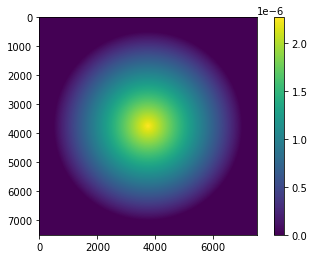

In [35]:
beam.generate_profile(pixel_size=pixel_size, lens_type=Lens.LensType.Spherical)

# set up the part of the lens square that isn't the lens for aperturing
non_lens_profile = beam.profile == 0 
aperturing_value = -1e-9
beam.profile[non_lens_profile] = aperturing_value

# calculate padding parameters
pad_width = (int(sim_width/pixel_size)-len(beam.profile))//2 + 1 
relative_position_x = int(beam_position[0]/pixel_size)
relative_position_y = int(beam_position[1]/pixel_size)

# pad the profile to the sim width (Top - Bottom - Left - Right)
beam.profile = np.pad(beam.profile, ((pad_width + relative_position_y, pad_width - relative_position_y),
                                             (pad_width + relative_position_x, pad_width - relative_position_x)))

# set up the sim padding to be apertured
beam.profile[:, :(pad_width + relative_position_y)] = aperturing_value
beam.profile[:, -(pad_width - relative_position_y):] = aperturing_value
beam.profile[:(pad_width + relative_position_x), :] = aperturing_value
beam.profile[-(pad_width - relative_position_x):, :] = aperturing_value


plt.imshow(beam.profile)
plt.colorbar()
plt.show()




In [36]:
start_distance = 0
finish_distance = 7e-3

In [37]:
# regular delta calculation
delta = (beam.medium.refractive_index-output_medium.refractive_index) * beam.profile
# regular phase calculation
phase = (2 * np.pi * delta / sim_wavelength) #% (2 * np.pi)

In [38]:
# regular wavefront calculation
wavefront = amplitude * np.exp(1j * phase)

# asymmetric aperturing (apply aperture mask)
wavefront[beam.profile==aperturing_value] = 0 + 0j

# regular wavefront FFT
wavefront = fftpack.fft2(wavefront)


In [39]:
# # regular wavefront calculation
# original_wavefront = amplitude * np.exp(1j * phase)
# plt.imshow(phase)
# # asymmetric aperturing (apply aperture mask)
# original_wavefront[beam.profile==aperturing_value] = 1000 + 0j
# plt.figure()
# plt.imshow(original_wavefront.real)
# # plt.imshow(original_wavefront.real)
# plt.colorbar()
# plt.show()

In [40]:
# regular frequency array creation
frequency_array = Simulation.generate_sq_freq_arr(sim_profile=beam.profile, pixel_size=pixel_size)

n_slices_1 = 20

sim = np.ones(shape=((n_slices_1), len(beam.profile[0]), len(beam.profile[1])))
distances_1 = np.linspace(start_distance, finish_distance, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * output_medium.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array) / output_medium.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft2(prop_1 * wavefront)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)
    
    sim[i] = np.round(output, 10)



KeyboardInterrupt: 

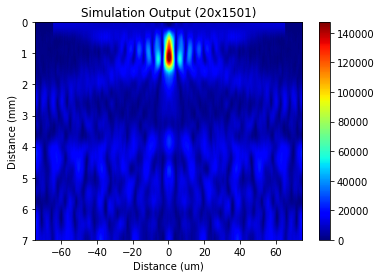

In [30]:
sim_to_show = sim[:, sim.shape[1]//2, :]

utils.plot_simulation(sim_to_show, sim_to_show.shape[1], sim_to_show.shape[0], pixel_size, start_distance, finish_distance)
plt.show()


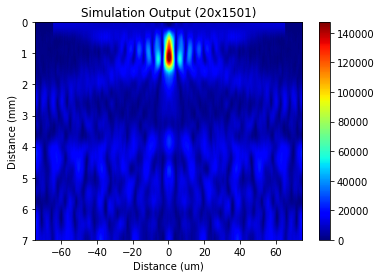

In [31]:
sim_to_show = sim[:, :, sim.shape[-1]//2]

utils.plot_simulation(sim_to_show, sim_to_show.shape[1], sim_to_show.shape[0], pixel_size, start_distance, finish_distance)
plt.show()

<Figure size 432x288 with 0 Axes>

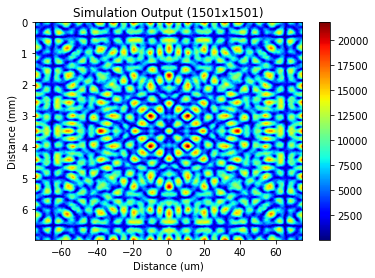

In [32]:
sim_to_show = sim[-1]
plt.figure()
utils.plot_simulation(sim_to_show, sim_to_show.shape[1], sim_to_show.shape[0], pixel_size, start_distance, finish_distance)
plt.show()

<Figure size 432x288 with 0 Axes>

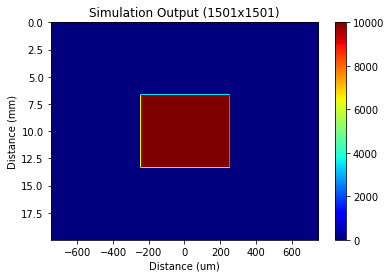

<Figure size 432x288 with 0 Axes>

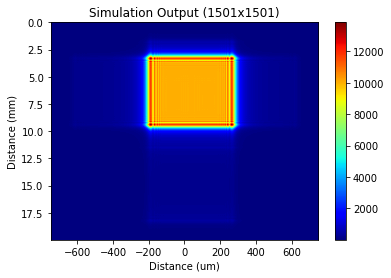

<Figure size 432x288 with 0 Axes>

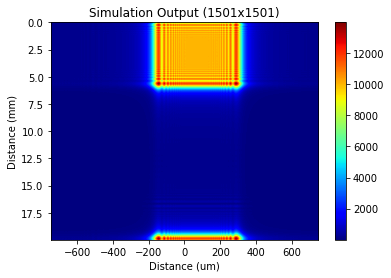

<Figure size 432x288 with 0 Axes>

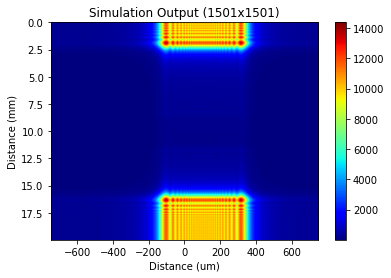

<Figure size 432x288 with 0 Axes>

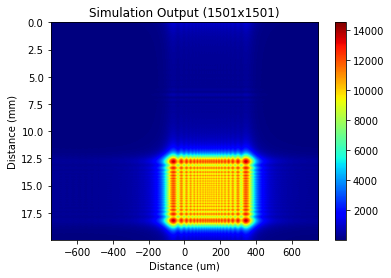

<Figure size 432x288 with 0 Axes>

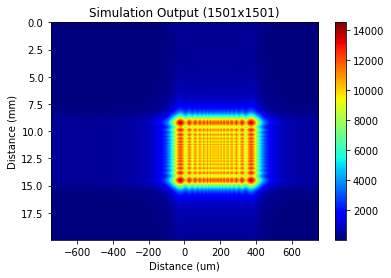

<Figure size 432x288 with 0 Axes>

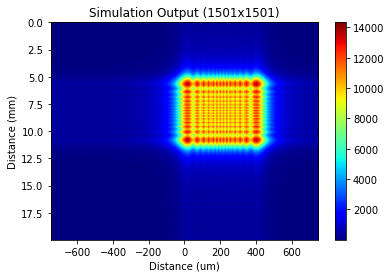

<Figure size 432x288 with 0 Axes>

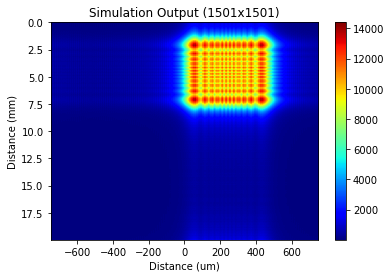

<Figure size 432x288 with 0 Axes>

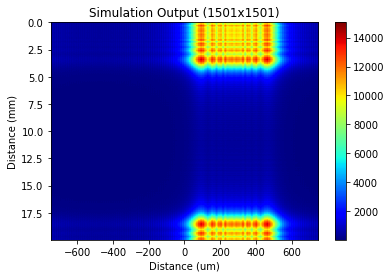

<Figure size 432x288 with 0 Axes>

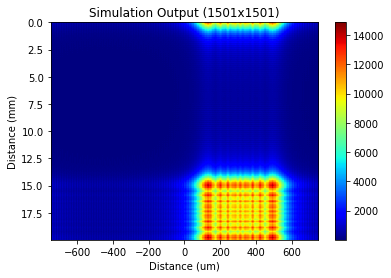

In [763]:
for sim_to_show in sim[::2]:
    plt.figure()
    utils.plot_simulation(sim_to_show, sim_to_show.shape[1], sim_to_show.shape[0], pixel_size, start_distance, finish_distance)
    plt.show()

### Error Checking

In [ ]:
# ERROR CHECKING #
# quick check on aperture validity
if (relative_position_x + beam_width/2) > sim_width:
    raise ValueError('Aperture cannot exist outside of simulation') 
if (relative_position_y + beam_width/2) > sim_width:
    raise ValueError('Aperture cannot exist outside of simulation') 
# if using diverging beam spread and DistanceMode.Width, the aperture must be smaller than the final_width
if beam_spread is BeamSpread.Diverging and distance_mode is DistanceMode.Width and final_beam_width < beam_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')
# likewise for using converging beam spread and DistanceMode.Width, the aperture must be larger than the final_width
if beam_spread is BeamSpread.Converging and distance_mode is DistanceMode.Width and final_beam_width > beam_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')


### Aperture/Beam definition

In [ ]:
# Beam settings chosen by user
beam_width = 400e-6
# position given relative to optical axis
beam_position = -100e-6

# this is selected by DistanceMode flag in config
distance_mode = DistanceMode.Width

# type of beam spread
beam_spread = BeamSpread.Converging

# calculate theta for non plane waves
if beam_spread is not BeamSpread.Plane:
    # Theta can either be specified directly, or by numerical aperture (config flag probably)
    theta = np.deg2rad(10) 
    # OR
    theta = theta_from_NA(numerical_aperture=0.4, output_medium=output_medium)

# perpendicular distance of source from the first lens can be defined directly (aperture distance) 
# or based on a desired beam width at the lens plane 
source_aperture_distance = 2000e-6
final_beam_width = 80e-6
if beam_spread is BeamSpread.Plane:
    final_beam_width = beam_width

# set tilt enabled based off flag
tilt_enabled = True
tilt_angle = np.deg2rad(85)

# Default beam specifications
aperture = Lens.Lens(
    diameter=beam_width,
    height=0.,
    exponent=2,
    medium=Lens.Medium(100)
)

# ERROR CHECKING #
# quick check on aperture validity
if (beam_position + beam_width/2) > sim_width:
    raise ValueError('Aperture cannot exist outside of simulation') 
# if using diverging beam spread and DistanceMode.Width, the aperture must be smaller than the final_width
if beam_spread is BeamSpread.Diverging and distance_mode is DistanceMode.Width and final_beam_width < beam_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')
# likewise for using converging beam spread and DistanceMode.Width, the aperture must be larger than the final_width
if beam_spread is BeamSpread.Converging and distance_mode is DistanceMode.Width and final_beam_width > beam_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')


#### Calculation of Convergence/Divergence

In [ ]:
if beam_spread is not BeamSpread.Plane:
    # calculate the equivalent focal distance of the required convergence angle
    focal_distance = focal_distance_from_theta(aperture=aperture, theta=theta)

    # calculate and set the height of the apertures 'virtual' lens, re-generate the profile with new height
    aperture.height = height_from_focal_distance(aperture, output_medium=output_medium, focal_distance=focal_distance)
    
    printing = False
    if printing:
        # Just some debugging prints, can remove if you want
        print(f'Angle of convergence: {np.rad2deg(theta)}')
        print(f'Focal distance wanted: {round(focal_distance*1e3, 3)}mm')
        print(f'Aperture height: {round(aperture.height*1e6, 3)}um')
        print(f'New Focal Distance: {round(Simulation.calculate_equivalent_focal_distance(aperture, output_medium)*1e3, 3)}mm')

aperture.generate_profile(pixel_size=pixel_size)

# possibly just invert lens
if beam_spread is BeamSpread.Diverging:
    aperture.profile = -aperture.profile + np.max(aperture.profile) 

### Calculation of aperture position and padding

In [ ]:

# calculate the relative position of the aperture in pixels
relative_position = int(beam_position/pixel_size)

# pad the aperture to the sim width
# plus one here is to make it 10001, not 9999
pad_width = (int(sim_width/pixel_size)-len(aperture.profile))//2 + 1 

# update the aperture profile
aperture.profile = np.pad(aperture.profile, (pad_width+relative_position, pad_width-relative_position), 'constant', constant_values=(0))
plt.plot(aperture.profile)

#### Calculation of Propagation Distance

In [ ]:
# Start distance of beam always = 0
start_distance = 0

# If you just want the source to be a certain distance away:
if distance_mode is DistanceMode.Direct or beam_spread is BeamSpread.Plane:
    finish_distance = source_aperture_distance

# if you want the beam to converge/diverge to a specific width
elif distance_mode is DistanceMode.Width:
    beam_radius = final_beam_width/2
    if beam_spread is BeamSpread.Converging:
        finish_distance = focal_distance - (beam_radius/np.tan(theta))
    else:
        finish_distance = ((beam_radius-(aperture.diameter/2))/np.tan(theta))
else:
    raise ValueError('DistanceMode set incorrectly')

### Delta, Tilt, Phase

In [ ]:
# regular delta calculation
delta = (aperture.medium.refractive_index-output_medium.refractive_index) * aperture.profile

# tilt the beam
if tilt_enabled:
    x = np.arange(len(aperture.profile))*pixel_size
    # modify the optical path of the light based on tilt
    delta = delta + x * np.tan(np.deg2rad(15))

# regular phase calculation
phase = (2 * np.pi * delta / sim_wavelength)# % (2 * np.pi)

### Wavefront Calculation

In [ ]:
# regular wavefront calculation
wavefront = amplitude * np.exp(1j * phase)

# asymmetric aperturing (apply aperture mask)
wavefront[:pad_width + relative_position] = 0 + 0j
wavefront[-(pad_width - relative_position):] = 0 + 0j

# regular wavefront FFT
wavefront = fftpack.fft(wavefront)

### Simulation

In [ ]:
# regular frequency array creation
frequency_array = Simulation.generate_squared_frequency_array(n_pixels=len(aperture.profile), pixel_size=pixel_size)

n_slices_1 = 100

sim = np.ones(shape=((n_slices_1), len(aperture.profile)))
distances_1 = np.linspace(start_distance, finish_distance, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * output_medium.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array) / output_medium.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_1 * wavefront)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim[i] = np.round(output, 10)


utils.plot_simulation(sim, sim.shape[1], sim.shape[0], pixel_size, start_distance, finish_distance)
plt.show()